In [1]:
import pandas as pd;
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

pd.set_option('display.float_format', lambda x: '%.2f' % x)
path = '../../../../k6/results/ssrh/'

def convert_to_MiB(value):
    if 'GiB' in value:
        return str(int(float(value.replace('GiB', '')) * 1024))
    if 'MiB' in value:
        return value.replace('MiB', '')
    if 'B' in value:
        return str(int(float(value.replace('B', '')) / 1024))
    return value

def detect_outliers(df, features, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    outliers = clf.fit_predict(df[features])
    return outliers == 1

def graph_row(plot_func, dataset, features, height=3, width=20):
    cols = len(features)
    fig, axes = plt.subplots(ncols=cols, figsize=(width, height))
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.05)
    for x, f in enumerate(features):
        plot_func(dataset, f, axes[x], idx=x)
    return plt

# 5.000 VUs

In [2]:
dirty_df = pd.read_csv(f'{path}5000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,discovery_cpu_percent,monolith_cpu_percent,recommendations_cpu_percent,teasers_cpu_percent,cdn_mem_percent,discovery_mem_percent,monolith_mem_percent,recommendations_mem_percent,...,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,35,0.00,3.05,118.10,23.49,22.12,0.35,0.80,37.23,2.37,...,6.93,5.29,14.48,417,83.20,83.00,84.00,416.00,0.00,0.00
1,40,0.00,2.00,142.67,22.20,28.69,0.35,0.80,37.58,2.35,...,7.03,5.81,18.80,417,83.40,83.00,84.00,417.00,0.00,0.00
2,45,0.00,3.47,118.99,26.49,20.90,0.35,0.82,37.64,2.26,...,6.83,5.79,14.62,416,83.40,83.00,84.00,417.00,0.00,0.00
3,50,0.00,1.92,116.25,26.85,24.01,0.35,0.82,37.90,2.34,...,6.79,4.94,13.07,417,83.20,83.00,84.00,416.00,0.00,0.00
4,55,0.00,1.97,133.49,23.40,23.62,0.35,0.84,38.07,2.39,...,6.80,5.83,14.35,417,83.40,83.00,84.00,417.00,0.00,0.00
5,60,0.00,2.17,127.12,19.30,22.84,0.35,0.85,38.27,2.32,...,6.74,5.72,19.27,416,83.40,83.00,84.00,417.00,0.00,0.00
6,65,0.00,1.77,120.58,19.68,23.74,0.35,0.86,38.52,2.25,...,6.66,5.88,13.60,417,83.20,83.00,84.00,416.00,0.00,0.00
7,70,0.00,2.33,126.12,25.98,21.23,0.35,0.86,38.75,2.36,...,6.62,5.37,13.73,417,83.40,83.00,84.00,417.00,0.00,0.00
8,75,0.00,1.69,117.17,22.22,22.48,0.35,0.86,38.93,2.30,...,6.68,5.70,16.34,416,83.40,83.00,84.00,417.00,0.00,0.00
9,80,0.00,1.78,118.93,23.09,21.86,0.35,0.86,39.10,2.02,...,6.63,5.58,14.41,417,83.20,83.00,84.00,416.00,0.00,0.00


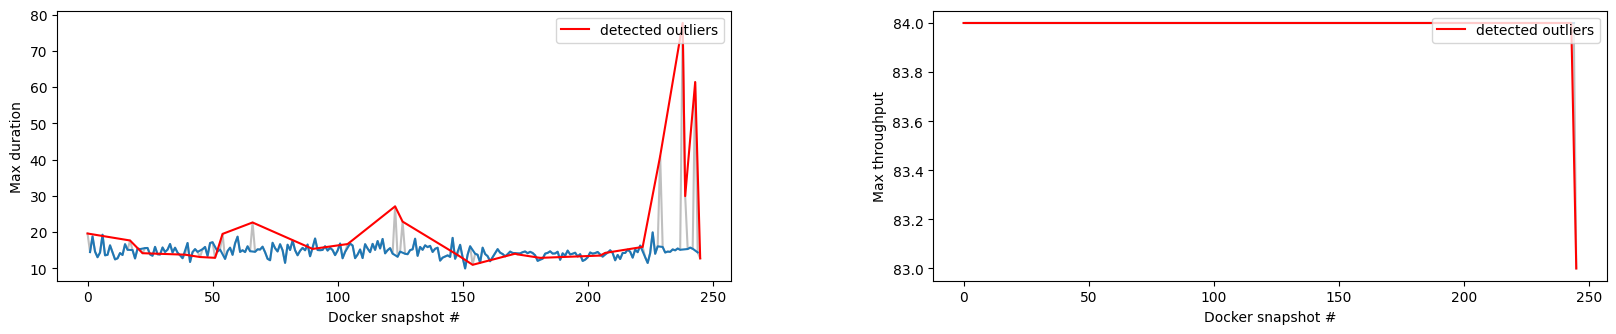

In [3]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

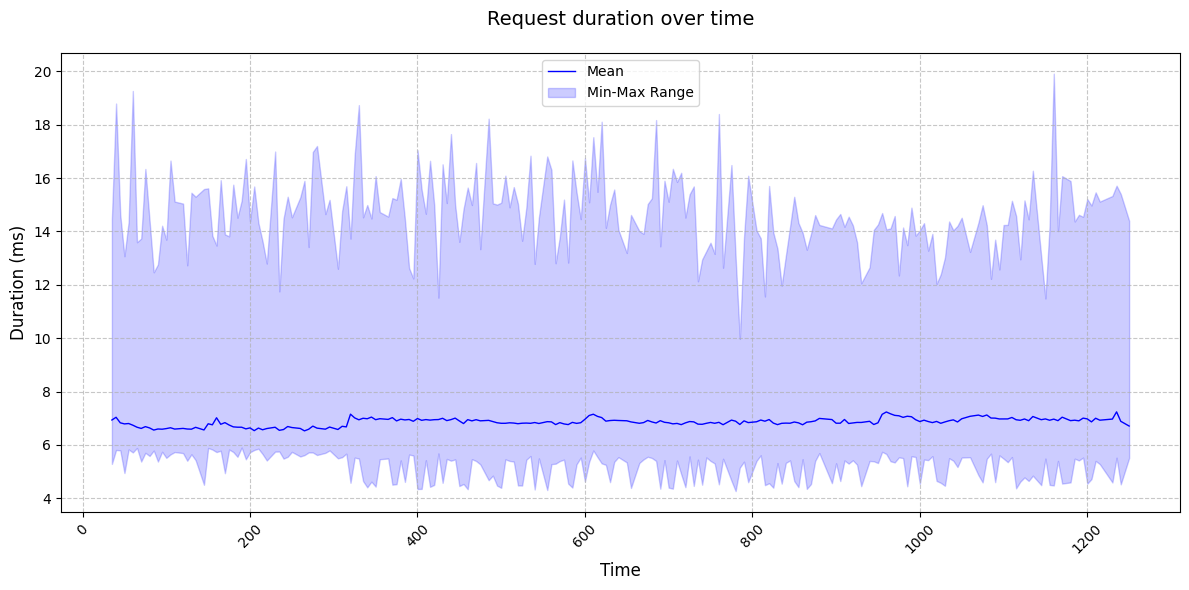

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

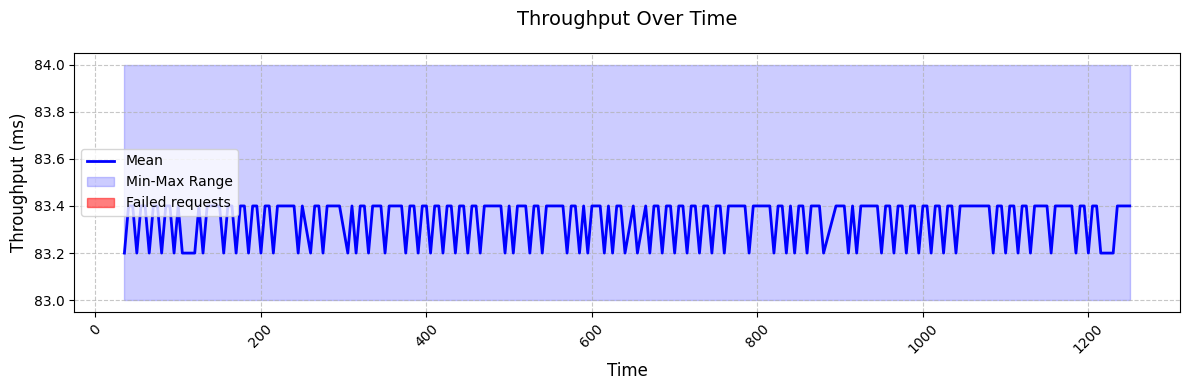

In [5]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

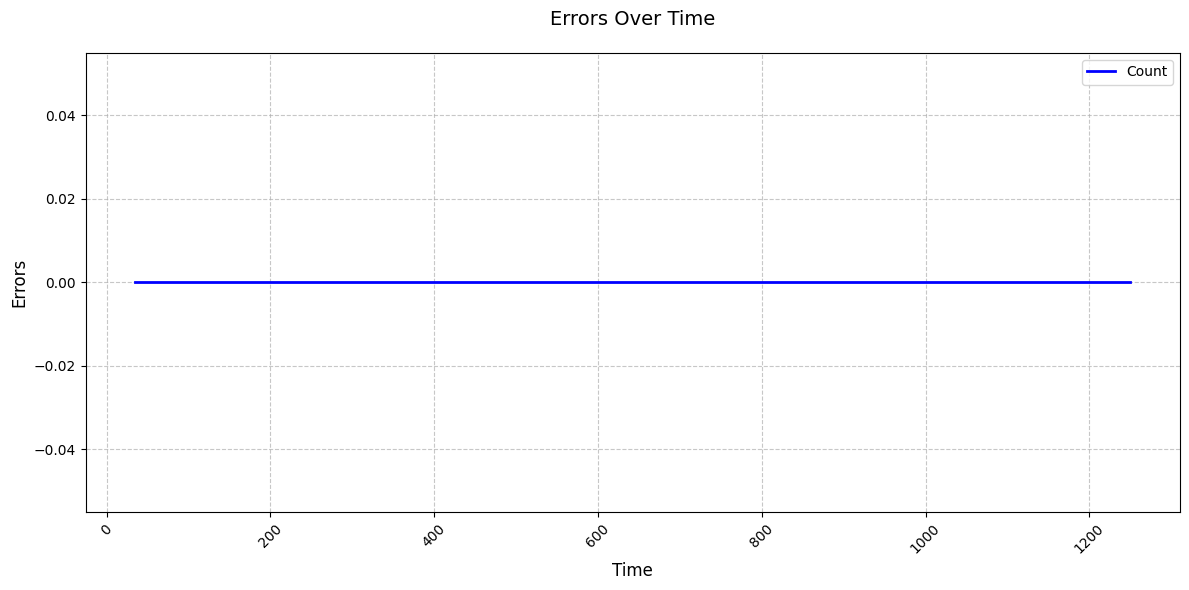

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 10.000 VUs

In [7]:
dirty_df = pd.read_csv(f'{path}10000/metrics.csv', sep=',')

duration = ['duration_mean', 'duration_min', 'duration_max', 'duration_count']
throughput = ['throughput_mean', 'throughput_min', 'throughput_max', 'throughput_count']
err = ['err_mean', 'err_count']

dirty_df = dirty_df[dirty_df['timestamp'] >= 30].dropna(subset=[*duration, *throughput]).reset_index(drop=True)

mask = detect_outliers(dirty_df, [*duration, *throughput])
df = dirty_df[mask].copy().reset_index(drop=True)

df.head(10)

,timestamp,cdn_cpu_percent,discovery_cpu_percent,monolith_cpu_percent,recommendations_cpu_percent,teasers_cpu_percent,cdn_mem_percent,discovery_mem_percent,monolith_mem_percent,recommendations_mem_percent,...,duration_mean,duration_min,duration_max,duration_count,throughput_mean,throughput_min,throughput_max,throughput_count,err_mean,err_count
0,30,0.00,4.02,134.55,36.85,34.69,0.23,0.72,38.10,3.89,...,7.17,5.70,50.86,834,166.60,166.00,167.00,833.00,0.00,0.00
1,35,0.00,3.44,132.03,37.53,35.19,0.23,0.72,38.33,3.90,...,6.95,5.45,35.73,833,166.80,166.00,167.00,834.00,0.00,0.00
2,40,0.01,4.00,143.01,37.91,34.38,0.23,0.72,38.65,3.98,...,6.89,5.59,32.98,833,166.60,166.00,167.00,833.00,0.00,0.00
3,45,0.00,3.64,131.53,37.11,33.65,0.23,0.72,38.89,4.02,...,7.05,5.15,24.07,834,166.60,166.00,168.00,833.00,0.00,0.00
4,55,0.00,3.64,136.88,36.97,34.22,0.23,0.73,39.53,4.06,...,7.17,5.56,65.05,833,166.60,166.00,167.00,833.00,0.00,0.00
5,60,0.00,3.40,133.67,37.19,51.77,0.23,0.73,40.11,4.08,...,6.86,4.46,29.37,834,166.60,166.00,167.00,833.00,0.00,0.00
6,65,0.00,3.60,131.16,35.85,33.04,0.23,0.73,40.30,4.12,...,6.83,5.34,40.39,833,166.80,166.00,167.00,834.00,0.00,0.00
7,70,0.01,3.77,131.59,46.87,34.66,0.23,0.73,40.50,4.13,...,6.65,5.45,17.32,833,166.60,166.00,167.00,833.00,0.00,0.00
8,75,0.00,4.21,130.37,36.66,33.84,0.23,0.73,40.87,4.15,...,6.91,4.49,32.20,834,166.60,166.00,167.00,833.00,0.00,0.00
9,80,0.00,3.78,131.20,35.78,34.36,0.23,0.73,41.16,4.15,...,6.73,4.26,31.49,833,166.80,166.00,167.00,834.00,0.00,0.00


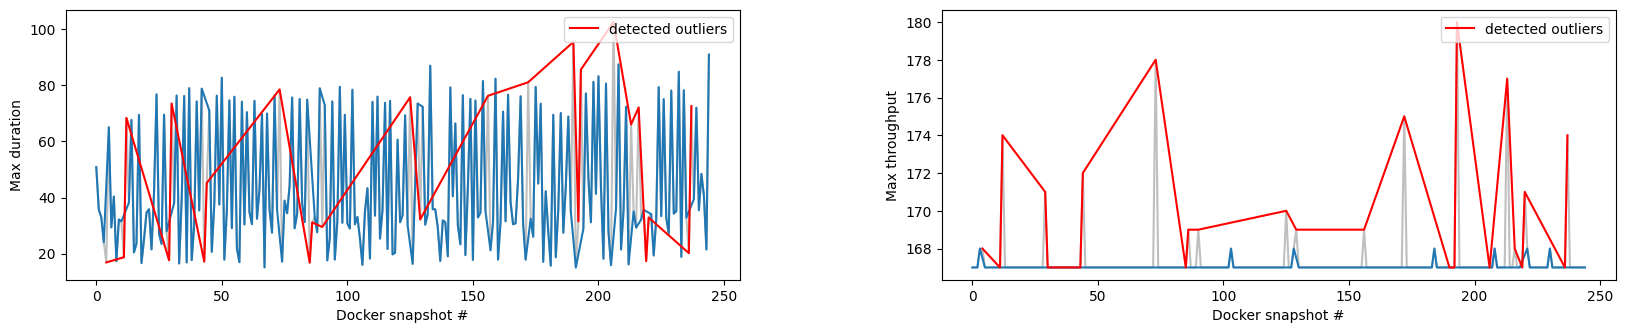

In [8]:
def plot_outliers(_df, f, loc, idx):
    loc.plot(_df[f'{f}_max'], color='gray', alpha=0.5)
    loc.plot(_df[f'{f}_max'][mask])
    loc.plot(_df[f'{f}_max'][~mask], label='detected outliers', color='red')

    loc.set_ylabel(f'Max {f}') 
    loc.set_xlabel('Docker snapshot #') 
    loc.legend(loc="upper right")

graph_row(plot_outliers, dirty_df, ['duration','throughput'])
plt.show()

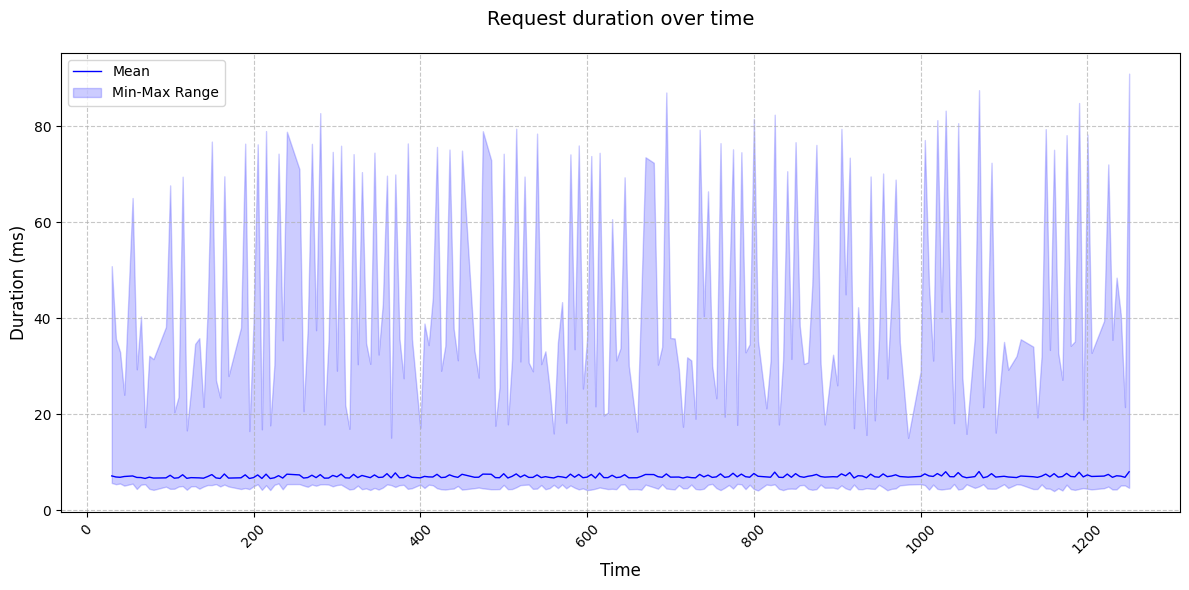

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['duration_mean'], 'b-', label='Mean', linewidth=1)

ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['duration_min'], df['duration_max'], where=(df['err_count'] > 1), color='red', alpha=0.5)

ax.set_title('Request duration over time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Duration (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

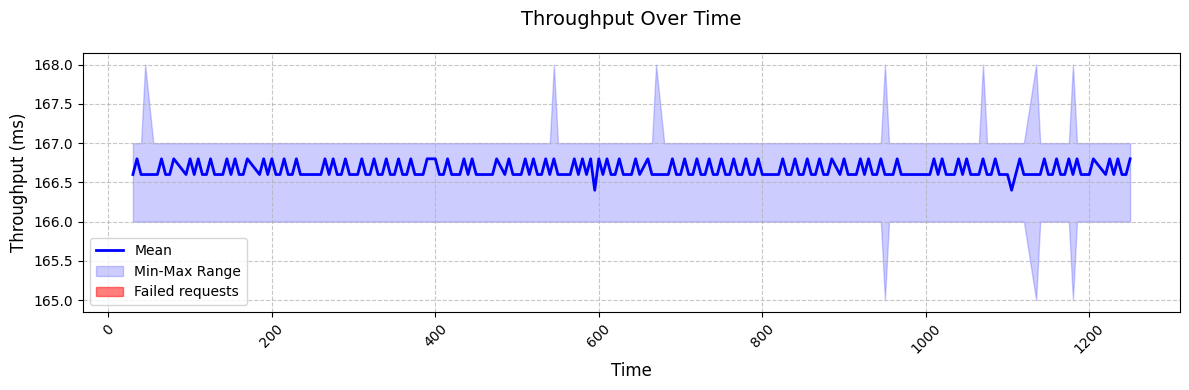

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df['timestamp'], df['throughput_mean'], 'b-', label='Mean', linewidth=2)

ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], alpha=0.2, color='blue', label='Min-Max Range')
ax.fill_between(df['timestamp'], df['throughput_min'], df['throughput_max'], where=(df['err_count'] > 1), color='red', alpha=0.5, label='Failed requests')

ax.set_title('Throughput Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Throughput (ms)', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

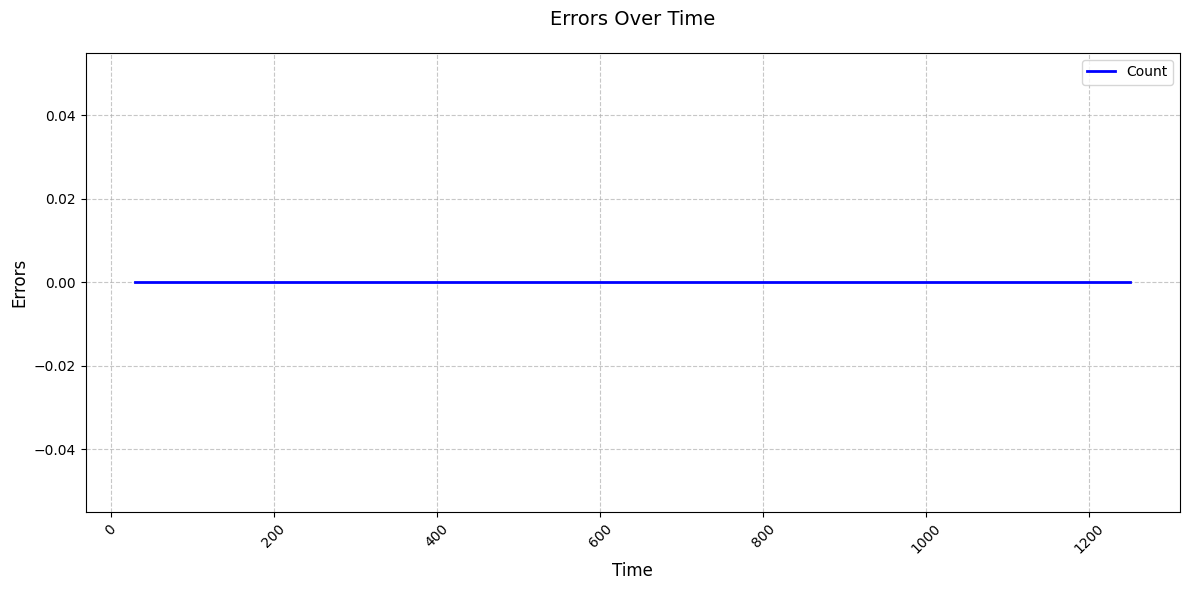

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['timestamp'], df['err_count'], 'b-', label='Count', linewidth=2)

ax.set_title('Errors Over Time', pad=20, size=14)
ax.set_xlabel('Time', size=12)
ax.set_ylabel('Errors', size=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()